<a href="https://colab.research.google.com/github/naderghanbari/mcgill-capstone/blob/master/capstone_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt

### Load dataset
In this step we load the data from 2015 to the end of 2019.

In [2]:
# Download the preprocessed dataset
%%bash
mkdir -p data
curl https://storage.googleapis.com/capstone-data-lake/aggregated/indicents_crimes_date_division.csv --silent --output data/indicents_crimes_date_division.csv
echo Number of lines: `wc -l data/*`

Number of lines: 12265 data/indicents_crimes_date_division.csv


In [36]:
df = pd.read_csv("data/indicents_crimes_date_division.csv", parse_dates=["date"])

# Keep only dates in the [2015, 2019] range
df = df[df["date"].between("2015-01-01", "2019-12-31")]

# Convert type to Pandas date type
df["date"] = df["date"].dt.date
df.set_index("date", drop=True, inplace=True)
df.head()

,division,incidents,units_deployed,crimes
date,,,,
2015-01-01,1,34,59,3
2015-01-01,2,81,140,15
2015-01-01,3,70,118,5
2015-01-01,4,70,92,8
2015-01-01,5,84,137,15


### Split by division
In this step we divide the dataset into chunks, one chunk
per division.

In [59]:
# Split the data for each division
division_dfs = [pd.DataFrame(y) for x, y in df.groupby("division", as_index=False)]

In [38]:
# Print the head of all division dataframes
[print(division_df.head()) for division_df in division_dfs];

            division  incidents  units_deployed  crimes
date                                                   
2015-01-01         1         34              59       3
2015-01-02         1         33              42       6
2015-01-03         1         38              69       5
2015-01-04         1        128             176       4
2015-01-05         1         52              97       9
            division  incidents  units_deployed  crimes
date                                                   
2015-01-01         2         81             140      15
2015-01-02         2         59              86       9
2015-01-03         2         63             128      14
2015-01-04         2        206             270       4
2015-01-05         2         99             168      20
            division  incidents  units_deployed  crimes
date                                                   
2015-01-01         3         70             118       5
2015-01-02         3         61             104 

### Visualizations

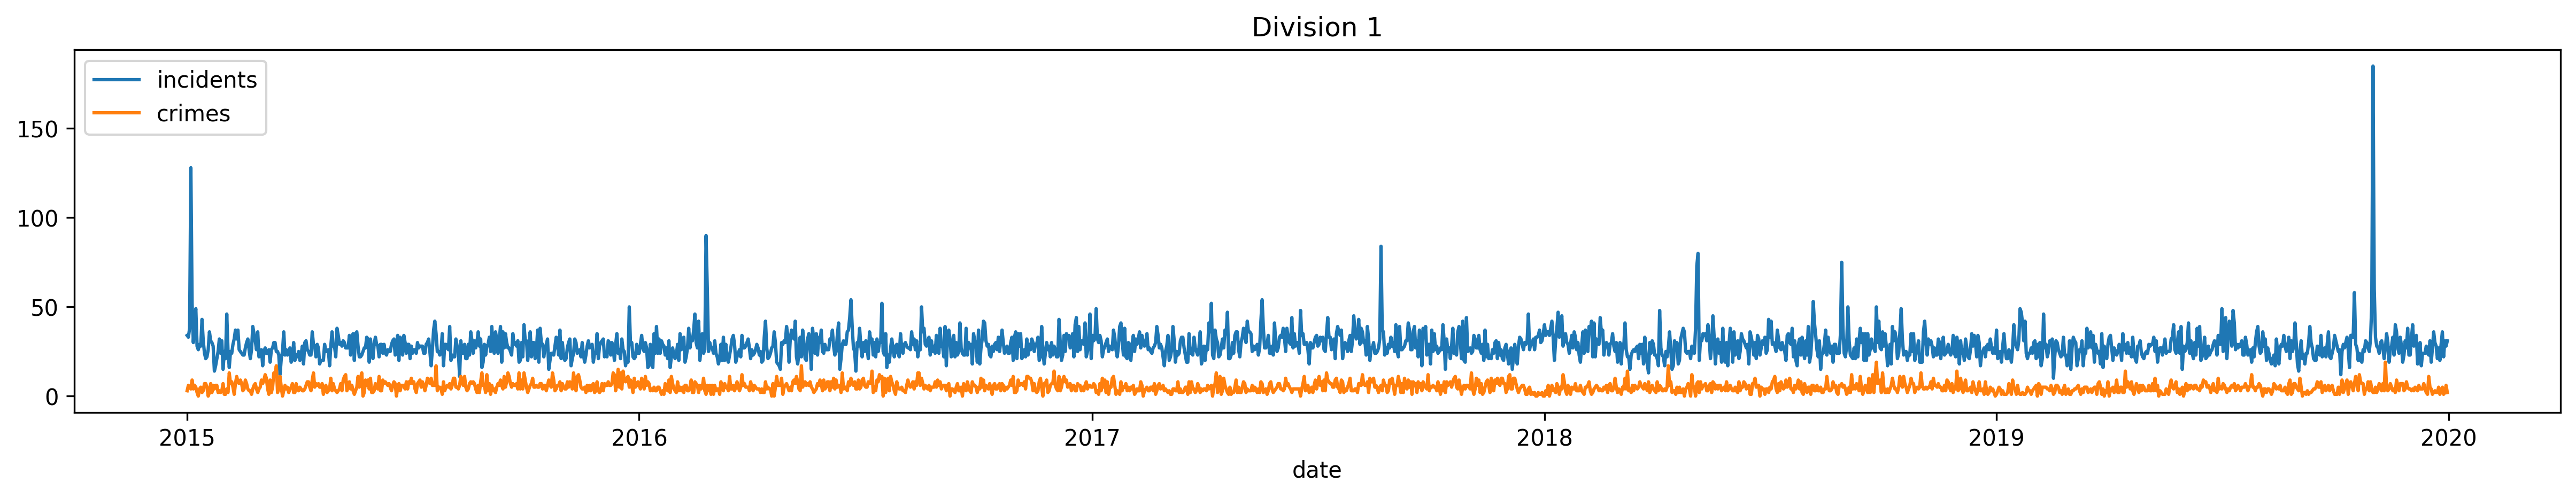

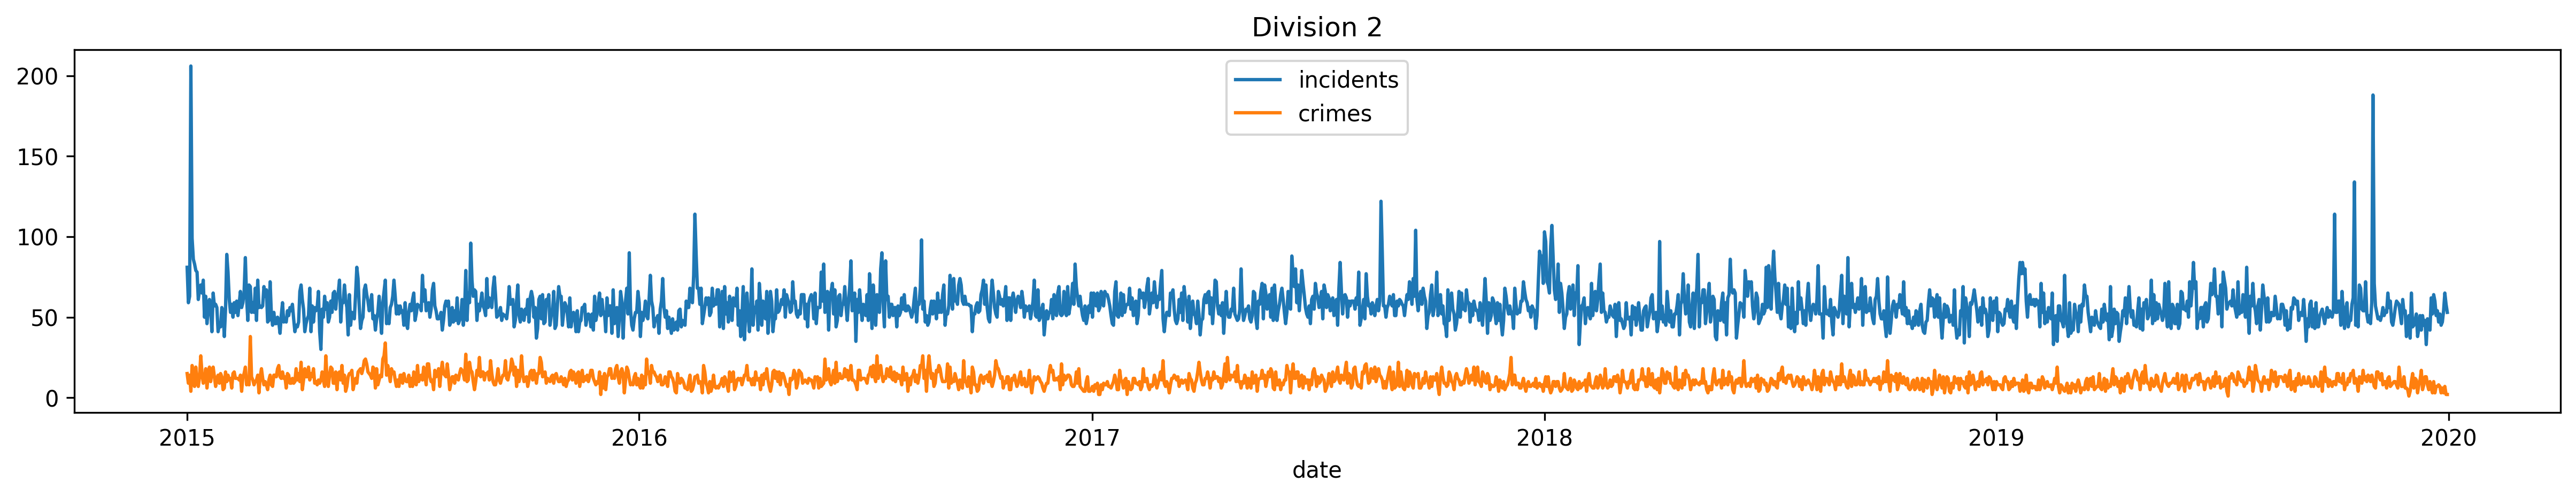

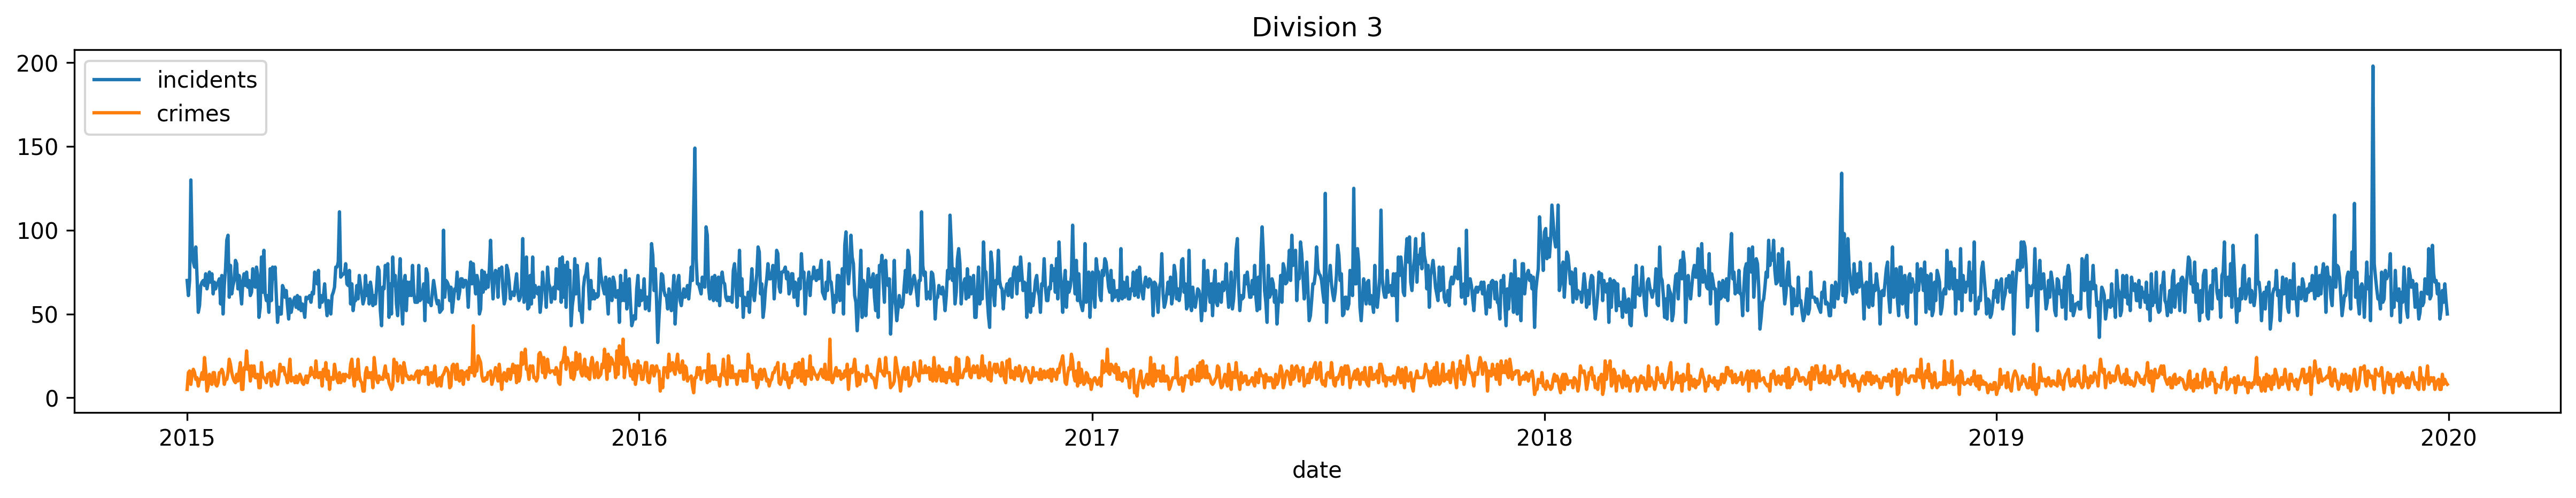

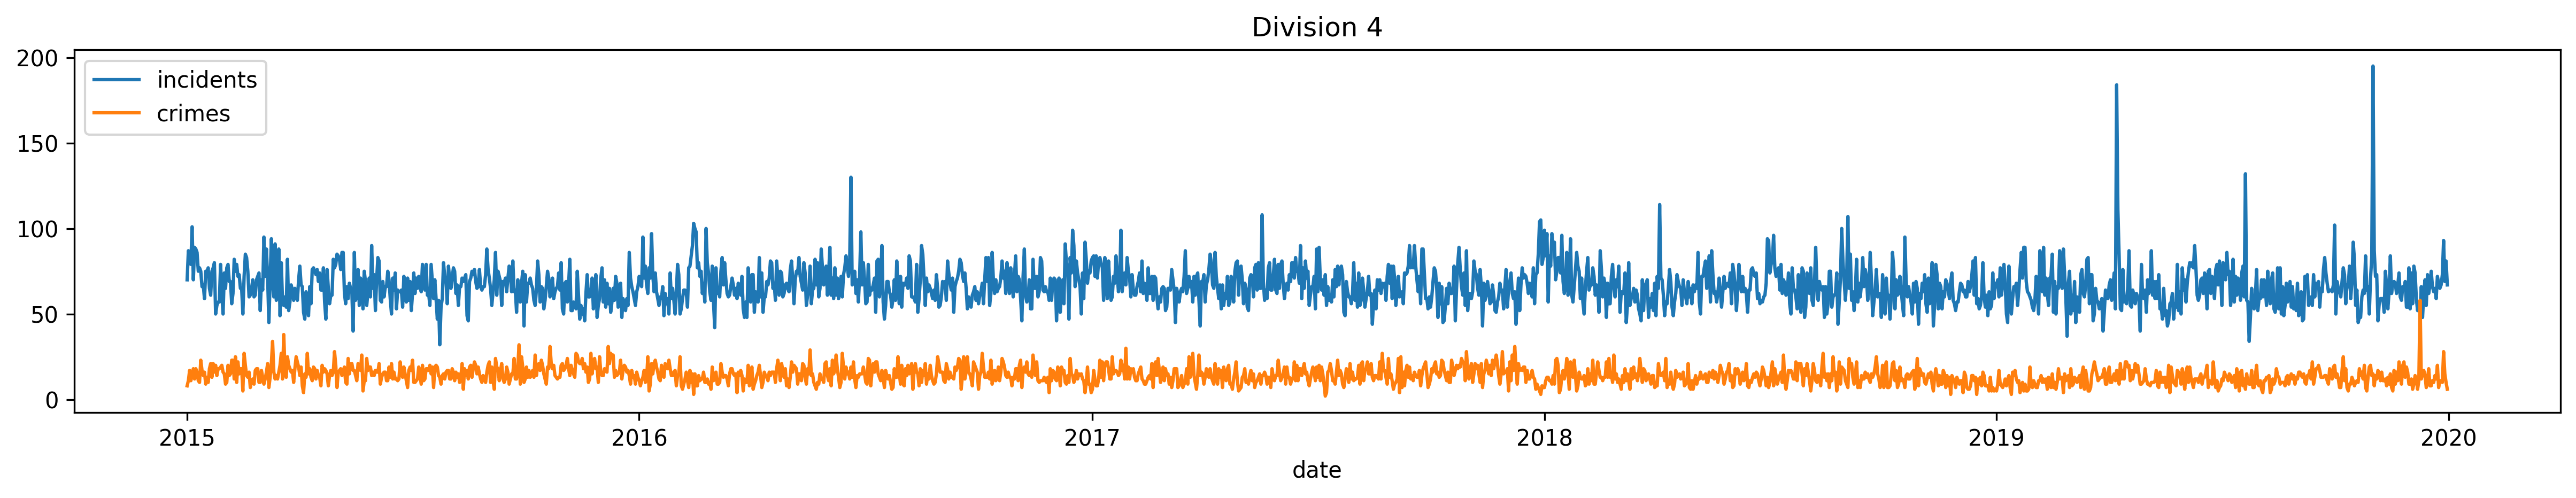

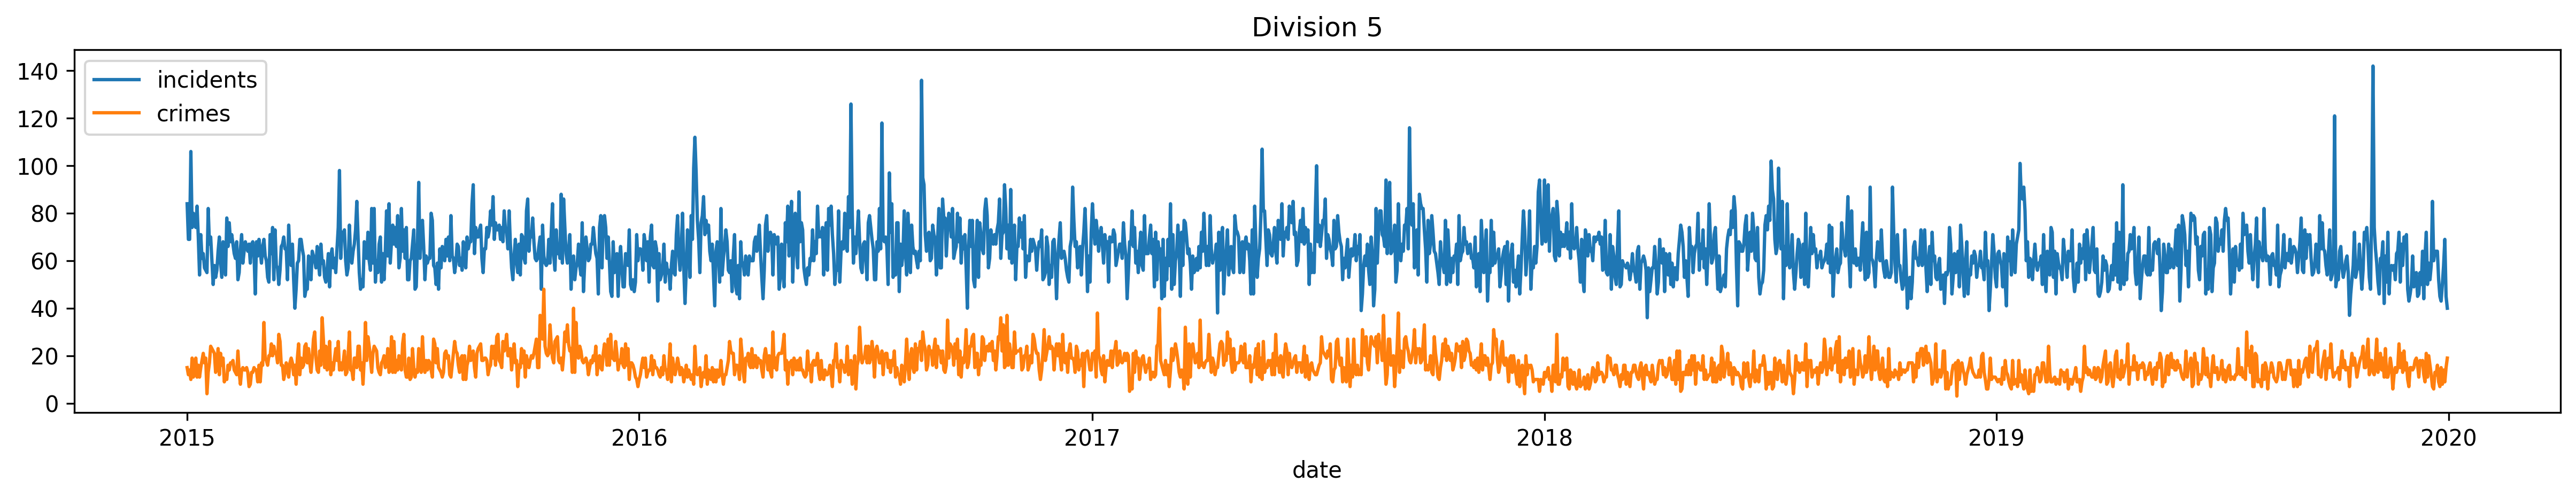

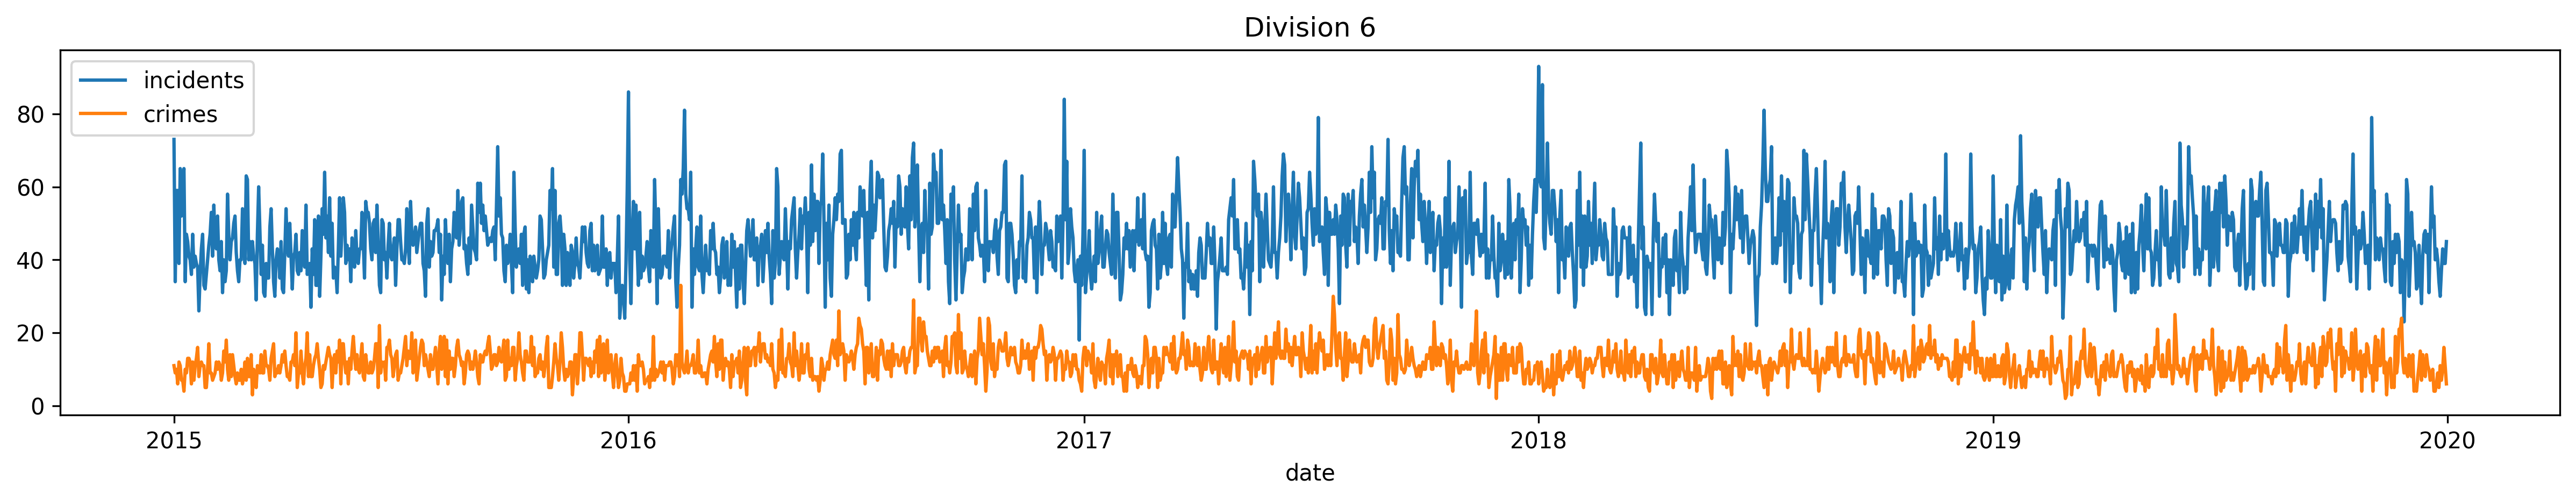

In [67]:
# Set plot size
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (20,3)

# Plot incidents and crimes for each division
for d, division_df in enumerate(division_dfs, start=1):
  division_df[["incidents", "crimes"]].plot(title=f"Division {d}");

# Windowing
In this step we prepare the data by adding engineered time-based features such as a window in the past.

In [32]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Test Training Split

- Random
- Squential (First 80% training, Last 20% test)